In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
reference: https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043

SyntaxError: ignored

In [5]:
'!ls -ltr "/content/drive/My Drive/Colab Notebooks/train.csv"'

-rw------- 1 root root 68802655 Dec  3 07:49 '/content/drive/My Drive/Colab Notebooks/train.csv'


In [6]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.3MB/s 
    100% |████████████████████████████████| 1.4MB 14.3MB/s 
    100% |████████████████████████████████| 133kB 29.5MB/s 
    100% |████████████████████████████████| 61kB 21.6MB/s 
    100% |████████████████████████████████| 5.1MB 6.6MB/s 
    100% |████████████████████████████████| 552kB 25.0MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [7]:
"!wget http://nlp.stanford.edu/data/glove.840B.300d.zip"

--2018-12-04 02:23:32--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2018-12-04 02:23:32--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  29.5MB/s    in 41s     

2018-12-04 02:24:14 (50.4 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]



In [8]:
"!unzip glove.840B.300d.zip"

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [9]:
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNLSTM
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import sys

########################################
## set directories and parameters
########################################



from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

Using TensorFlow backend.


In [10]:
path = "/content/drive/My Drive/Colab Notebooks/"
EMBEDDING_FILE='glove.840B.300d.txt'
TRAIN_DATA_FILE=path + 'train.csv'
TEST_DATA_FILE=path + 'test.csv'

MAX_SEQUENCE_LENGTH = 150
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

num_lstm = 300
num_dense = 256
rate_drop_lstm = 0.25
rate_drop_dense = 0.25

act = 'relu'

########################################
## index word vectors
########################################
print('Indexing word vectors')

#Glove Vectors
embeddings_index = {}
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    try:
      coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
      lenofvalues = len(values)
      print(lenofvalues)
      coefs = np.asarray(values[-300:], dtype='float32')
      how_many_words = lenofvalues - 300
      print("how_many_words", how_many_words)
      word = " ".join(values[:how_many_words])
      print(word)
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

Indexing word vectors
303
how_many_words 3
. . .
302
how_many_words 2
at name@domain.com
305
how_many_words 5
. . . . .
302
how_many_words 2
to name@domain.com
302
how_many_words 2
. .
304
how_many_words 4
. . . .
302
how_many_words 2
email name@domain.com
302
how_many_words 2
or name@domain.com
302
how_many_words 2
contact name@domain.com
302
how_many_words 2
Email name@domain.com
302
how_many_words 2
on name@domain.com
302
how_many_words 2
At Killerseats.com
302
how_many_words 2
by name@domain.com
302
how_many_words 2
in mylot.com
302
how_many_words 2
emailing name@domain.com
302
how_many_words 2
Contact name@domain.com
302
how_many_words 2
at name@domain.com
302
how_many_words 2
• name@domain.com
302
how_many_words 2
at Amazon.com
302
how_many_words 2
is name@domain.com
Total 2195903 word vectors.


In [11]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
########################################
## process texts in datasets
########################################
print('Processing text dataset')

#Regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

#regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    
    #Remove Special Characters
    text=special_character_removal.sub('',text)
    
    #Replace Numbers
    text=replace_numbers.sub('n',text)

    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)


list_sentences_train = train_df["comment_text"].fillna("NA").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_test = test_df["comment_text"].fillna("NA").values


comments = []
for text in list_sentences_train:
    comments.append(text_to_wordlist(text))
    
test_comments=[]
for text in list_sentences_test:
    test_comments.append(text_to_wordlist(text))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments + test_comments)

sequences = tokenizer.texts_to_sequences(comments)
test_sequences = tokenizer.texts_to_sequences(test_comments)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor:', test_data.shape)

Processing text dataset
Found 392183 unique tokens
Shape of data tensor: (159571, 150)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 150)


In [13]:
########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 25722


In [14]:
########################################
## sample train/validation data
########################################
# np.random.seed(1234)
perm = np.random.permutation(len(data))
idx_train = perm[:int(len(data)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data)*(1-VALIDATION_SPLIT)):]

data_train=data[idx_train]
labels_train=y[idx_train]
print(data_train.shape,labels_train.shape)

data_val=data[idx_val]
labels_val=y[idx_val]

print(data_val.shape,labels_val.shape)

(143613, 150) (143613, 6)
(15958, 150) (15958, 6)


In [0]:
########################################
## define the model structure
########################################
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm,
                  recurrent_dropout=rate_drop_lstm, return_sequences=True)

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences= embedding_layer(comment_input)
x = lstm_layer(embedded_sequences)
x = Dropout(rate_drop_dense)(x)
merged = Attention(MAX_SEQUENCE_LENGTH)(x)
merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)
preds = Dense(6, activation='sigmoid')(merged)

In [16]:
########################################
## train the model
########################################
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

STAMP = 'simple_lstm_glove_vectors_%.2f_%.2f'%(rate_drop_lstm,rate_drop_dense)
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=5)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit(data_train, labels_train, validation_data=(data_val, labels_val),
                 epochs=3, batch_size=256, shuffle=True,
                 callbacks=[early_stopping, model_checkpoint])
         
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          30000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 300)          721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
attention_1 (Attention)      (None, 300)               450       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [18]:
#######################################
## make the submission
########################################
print('Start making the submission before fine-tuning')

y_test = model.predict([test_data], batch_size=1024, verbose=1)

sample_submission = pd.read_csv(path + "sample_submission.csv")
sample_submission[list_classes] = y_test

sample_submission.to_csv('%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)

Start making the submission before fine-tuning
153164/153164 [==============================] - 1130s 7ms/step


In [19]:
bst_val_score

0.04455192511529384

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [0]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

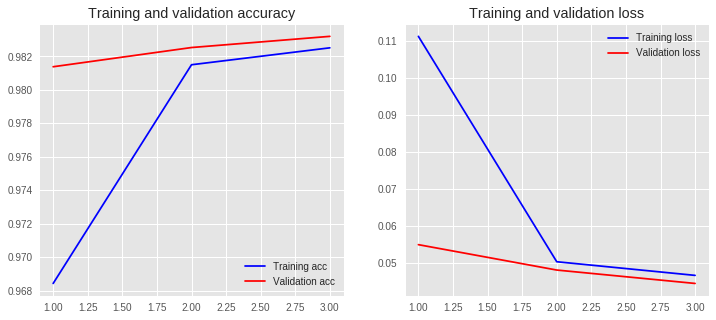

In [23]:
plot_history(hist)